# Coronary Stenosis Detection - vast.ai (RTX 5090)
Python port of the MATLAB stenosis detection pipeline from SAM-VMNet.

**Pipeline:** Segmentation mask → Skeletonize → Measure radii → Find bifurcations → BFS paths → Detect V-shape narrowing → Classify severity

## 1. Setup (run once)

In [1]:
# All deps already installed in /venv/main (PyTorch 2.10 + CUDA 13.0, scikit-image, scipy, etc.)
# If you ever need to install something:
# !pip install -q <package>

In [2]:
import sys, os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Absolute path on vast.ai instance
PROJECT_ROOT = Path('/workspace/SAM-VMNet')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

os.chdir(PROJECT_ROOT)

from stenosis_detection.stenosis_detection import run_stenosis_detection, plot_results

%matplotlib inline
plt.rcParams['figure.dpi'] = 120
print(f'Working dir: {Path.cwd()}')
print(f'GPU: {__import__("torch").cuda.get_device_name(0)}')
print('Ready!')

Working dir: /workspace/SAM-VMNet
GPU: NVIDIA GeForce RTX 5090
Ready!


## 2. Set your image paths
You need two images:
1. **Original** angiography image
2. **Segmented mask** (binary vessel mask from SAM-VMNet or other segmentation)

In [3]:
# === Image paths (absolute, on vast.ai instance) ===
DATA_ROOT = PROJECT_ROOT / 'data' / 'vessel' / 'test'

# Pick a sample image (1-300 available)
SAMPLE = '1.png'
ORIGINAL_IMG = str(DATA_ROOT / 'images' / SAMPLE)
MASK_IMG     = str(DATA_ROOT / 'masks'  / SAMPLE)

# Verify files exist
for p in [ORIGINAL_IMG, MASK_IMG]:
    if os.path.exists(p):
        print(f'OK: {p}')
    else:
        print(f'MISSING: {p}')

OK: /workspace/SAM-VMNet/data/vessel/test/images/1.png
OK: /workspace/SAM-VMNet/data/vessel/test/masks/1.png


## 3. Preview inputs

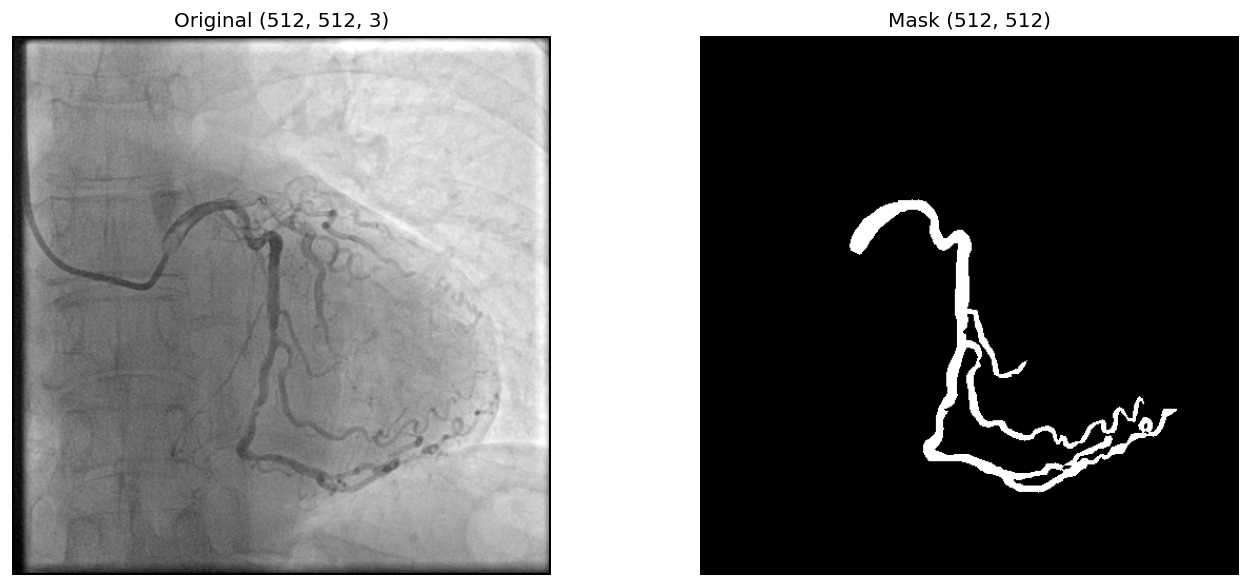

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

orig = cv2.imread(ORIGINAL_IMG)
if orig is not None:
    ax1.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    ax1.set_title(f'Original {orig.shape}')
else:
    ax1.text(0.5, 0.5, 'File not found', ha='center')
ax1.axis('off')

mask = cv2.imread(MASK_IMG, cv2.IMREAD_GRAYSCALE)
if mask is not None:
    ax2.imshow(mask, cmap='gray')
    ax2.set_title(f'Mask {mask.shape}')
else:
    ax2.text(0.5, 0.5, 'File not found', ha='center')
ax2.axis('off')
plt.tight_layout()
plt.show()

## 4. Run Stenosis Detection

In [5]:
%%time
print('Running stenosis detection...')
result = run_stenosis_detection(ORIGINAL_IMG, MASK_IMG)
print('Done!')

Running stenosis detection...
  Skeleton points: 1589
  Radii computed: 1589
  Bifurcation points: 61
  Filtered bifurcations: 16
  Stenosis points found: 1
    [MILD] Point (280, 303): 30.4%
Done!
CPU times: user 1min 40s, sys: 15.8 ms, total: 1min 40s
Wall time: 1min 40s


Saved to stenosis_result.png


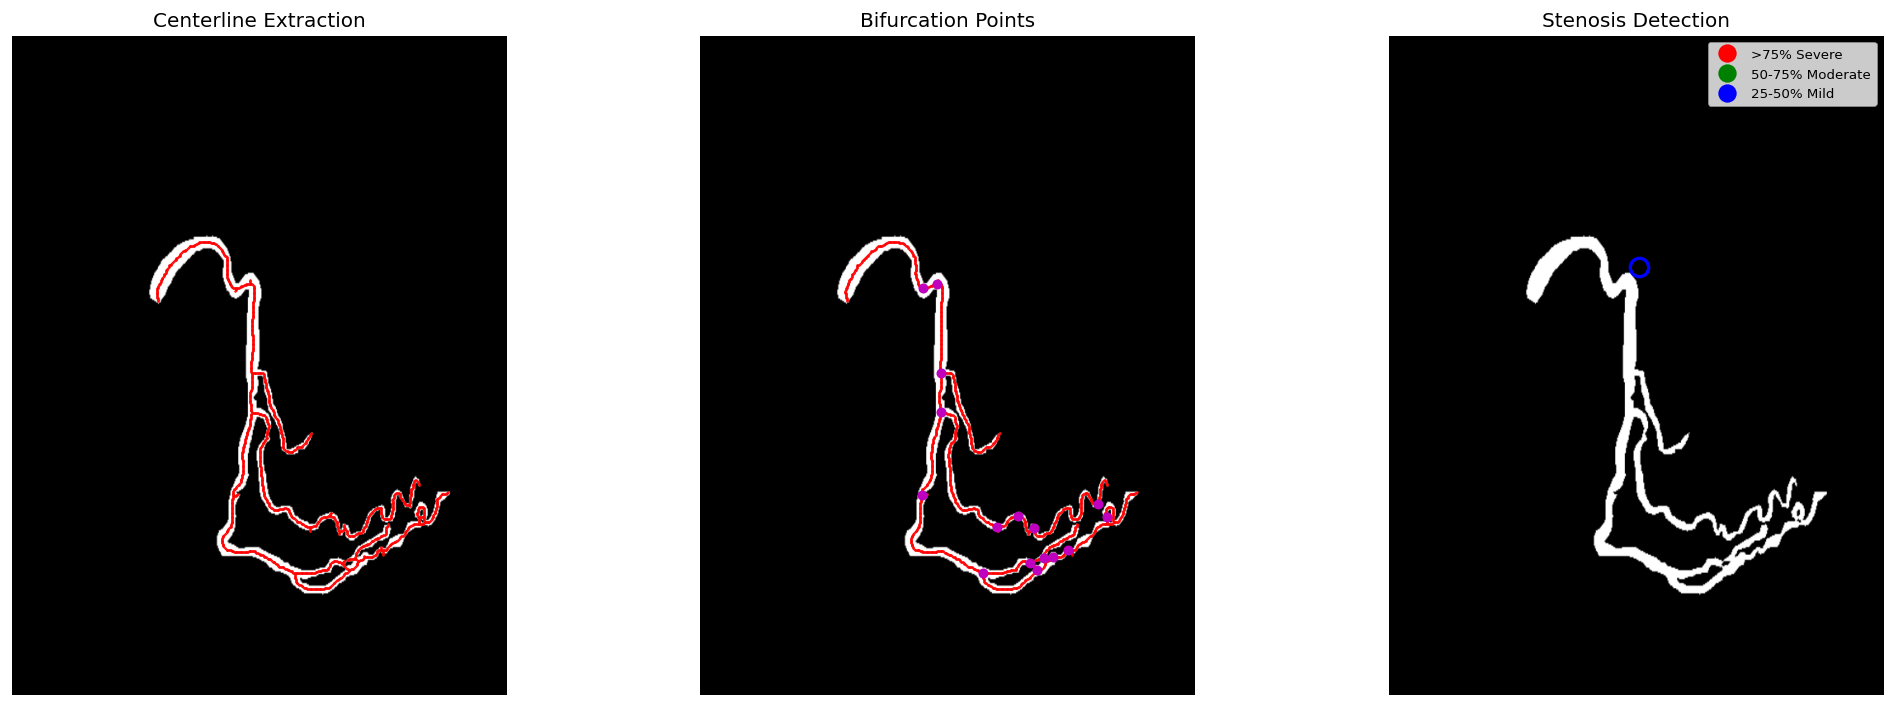

In [6]:
# Visualize all 3 stages
plot_results(result, save_path='stenosis_result.png')

## 5. Detailed results

In [7]:
pts = result['points']
degs = result['degrees']

print(f"Total stenosis points: {len(degs)}")
print(f"Skeleton points: {len(result['skeleton_coords'][0])}")
print(f"Bifurcation points: {len(result['bifurcations'])}")
print()

if len(degs) > 0:
    print(f"{'#':<4} {'Location':<20} {'Degree':<10} {'Severity'}")
    print('-' * 50)
    for i, d in enumerate(degs):
        sev = 'SEVERE (>75%)' if d > 0.75 else 'MODERATE (50-75%)' if d > 0.5 else 'MILD (25-50%)'
        print(f"{i+1:<4} ({pts[i,0]:.0f}, {pts[i,1]:.0f}){'':<10} {d*100:.1f}%{'':<5} {sev}")
else:
    print('No stenosis detected.')

Total stenosis points: 1
Skeleton points: 1589
Bifurcation points: 16

#    Location             Degree     Severity
--------------------------------------------------
1    (280, 303)           30.4%      MILD (25-50%)


## 6. Batch processing (optional)
Process multiple image pairs at once.

Found 300 images
  Processing 1.png...
  Skeleton points: 1589
  Radii computed: 1589
  Bifurcation points: 61
  Filtered bifurcations: 16
  Stenosis points found: 1
    [MILD] Point (280, 303): 30.4%
Saved to /workspace/SAM-VMNet/stenosis_results/result_1.png


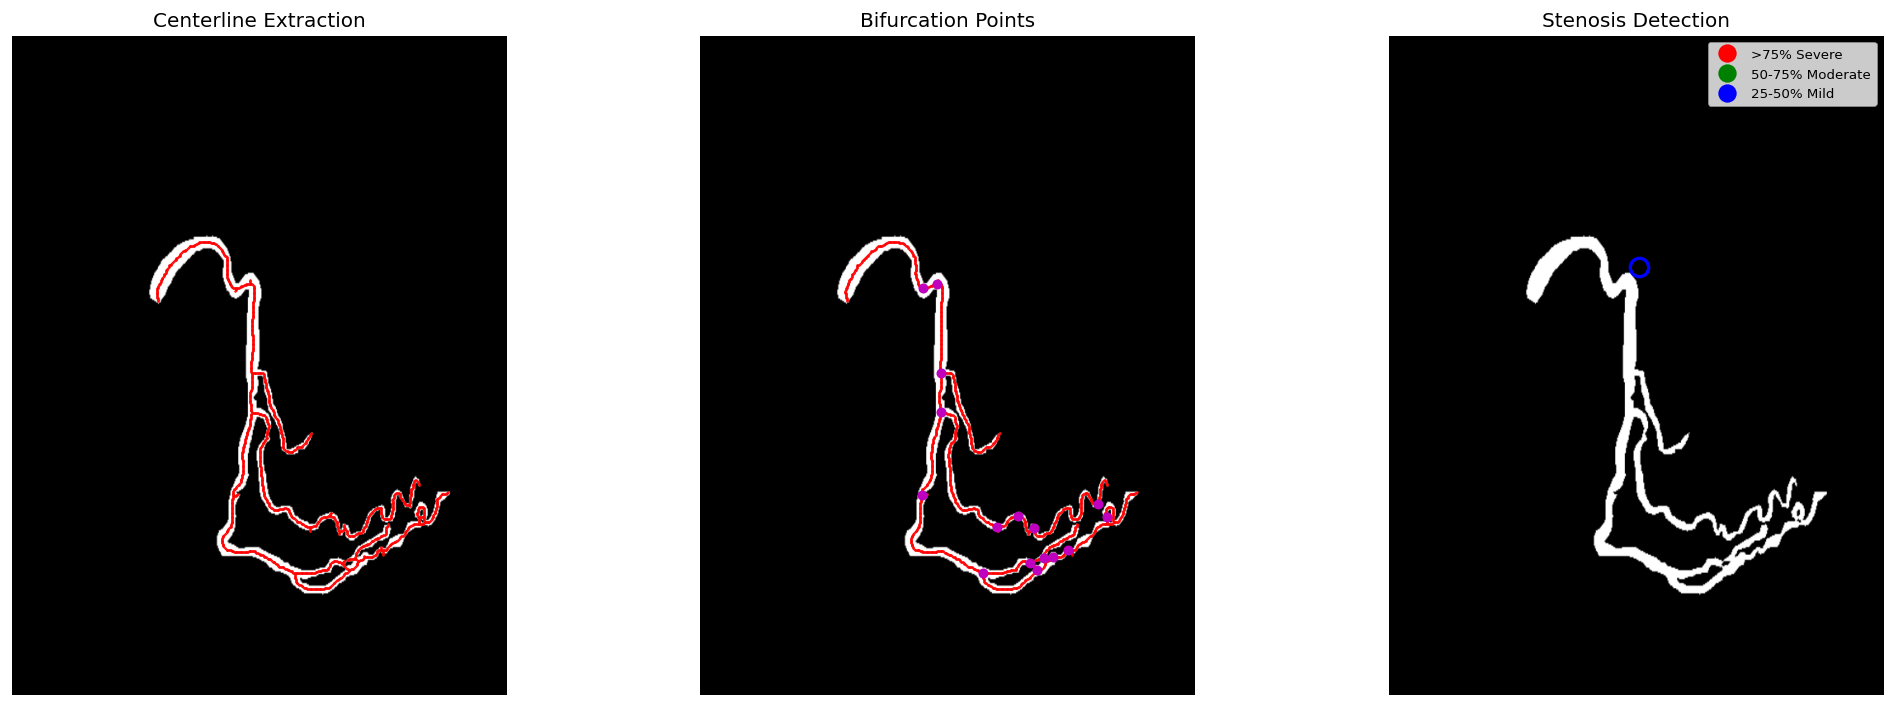

  Processing 10.png...
  Skeleton points: 1688
  Radii computed: 1688
  Bifurcation points: 38
  Filtered bifurcations: 9
  Stenosis points found: 4
    [MILD] Point (110, 105): 31.7%
    [SEVERE] Point (126, 105): 83.3%
    [MODERATE] Point (157, 103): 52.4%
    [MILD] Point (294, 274): 39.4%
Saved to /workspace/SAM-VMNet/stenosis_results/result_10.png


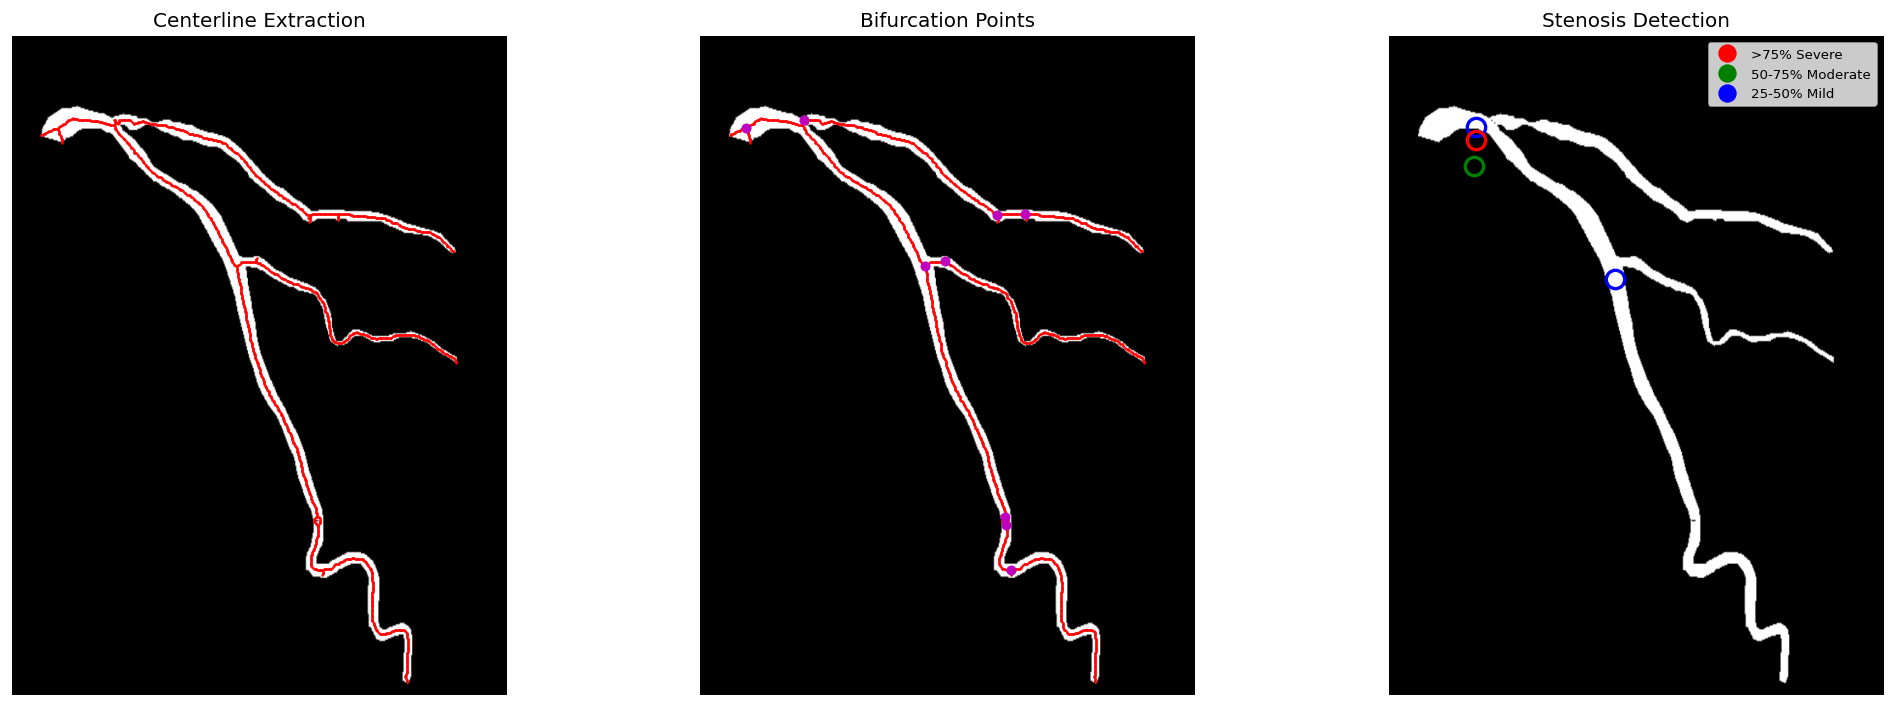

  Processing 100.png...
  Skeleton points: 1562
  Radii computed: 1562
  Bifurcation points: 66
  Filtered bifurcations: 14
  Stenosis points found: 9
    [SEVERE] Point (164, 152): 92.6%
    [MODERATE] Point (194, 239): 54.5%
    [MILD] Point (209, 226): 38.5%
    [MILD] Point (242, 119): 41.9%
    [MILD] Point (290, 227): 40.7%
    [MILD] Point (331, 238): 46.7%
    [MILD] Point (379, 290): 28.0%
    [MILD] Point (407, 325): 36.0%
    [MILD] Point (491, 402): 27.3%
Saved to /workspace/SAM-VMNet/stenosis_results/result_100.png


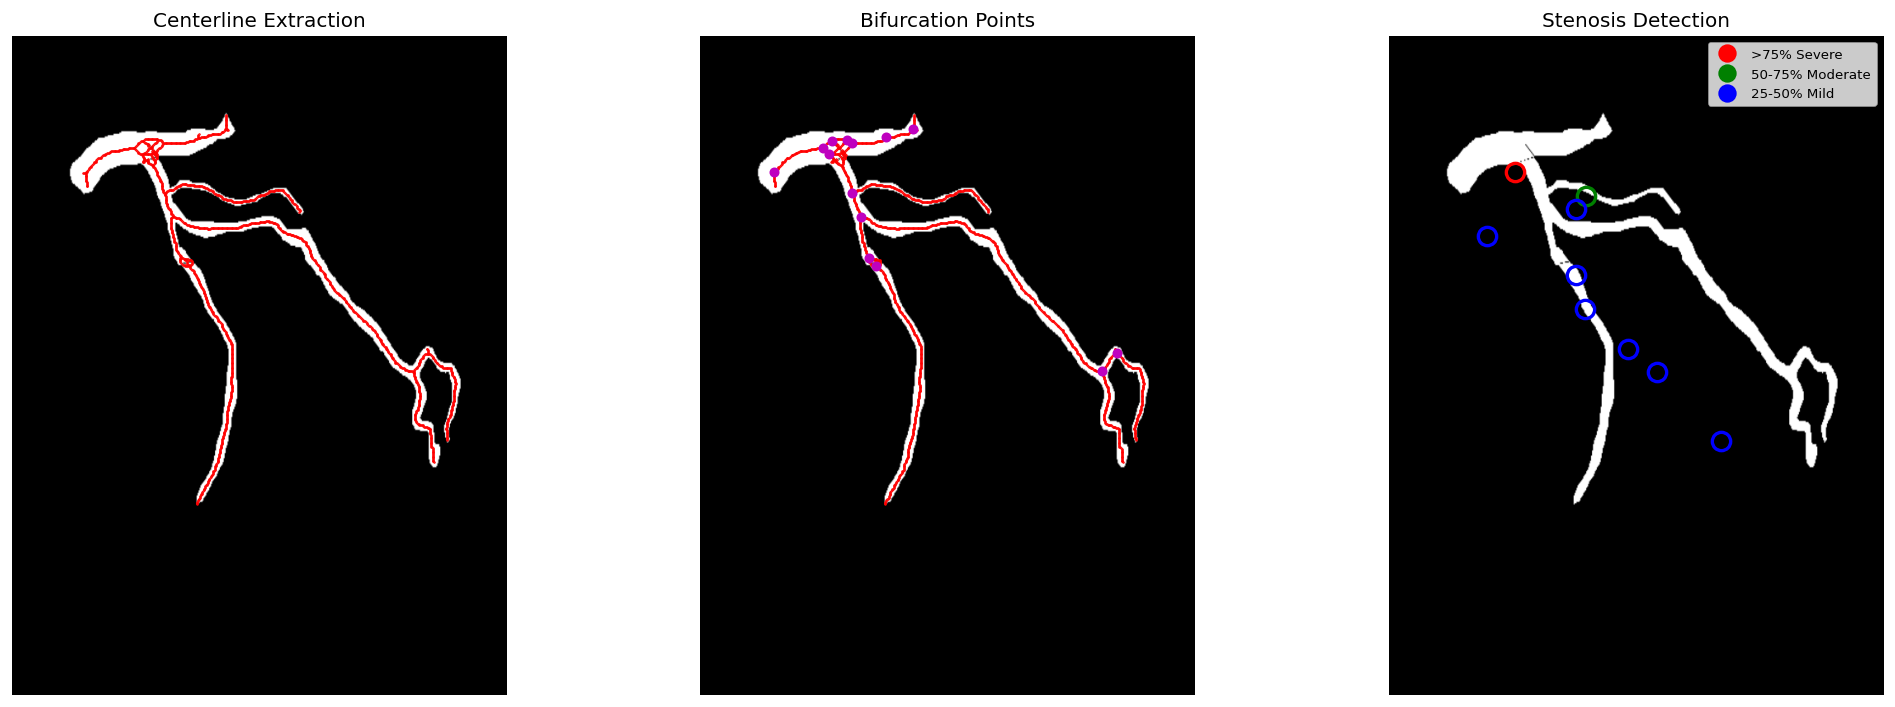

  Processing 101.png...
  Skeleton points: 733
  Radii computed: 733
  Bifurcation points: 3
  Filtered bifurcations: 1
  Stenosis points found: 0
Saved to /workspace/SAM-VMNet/stenosis_results/result_101.png


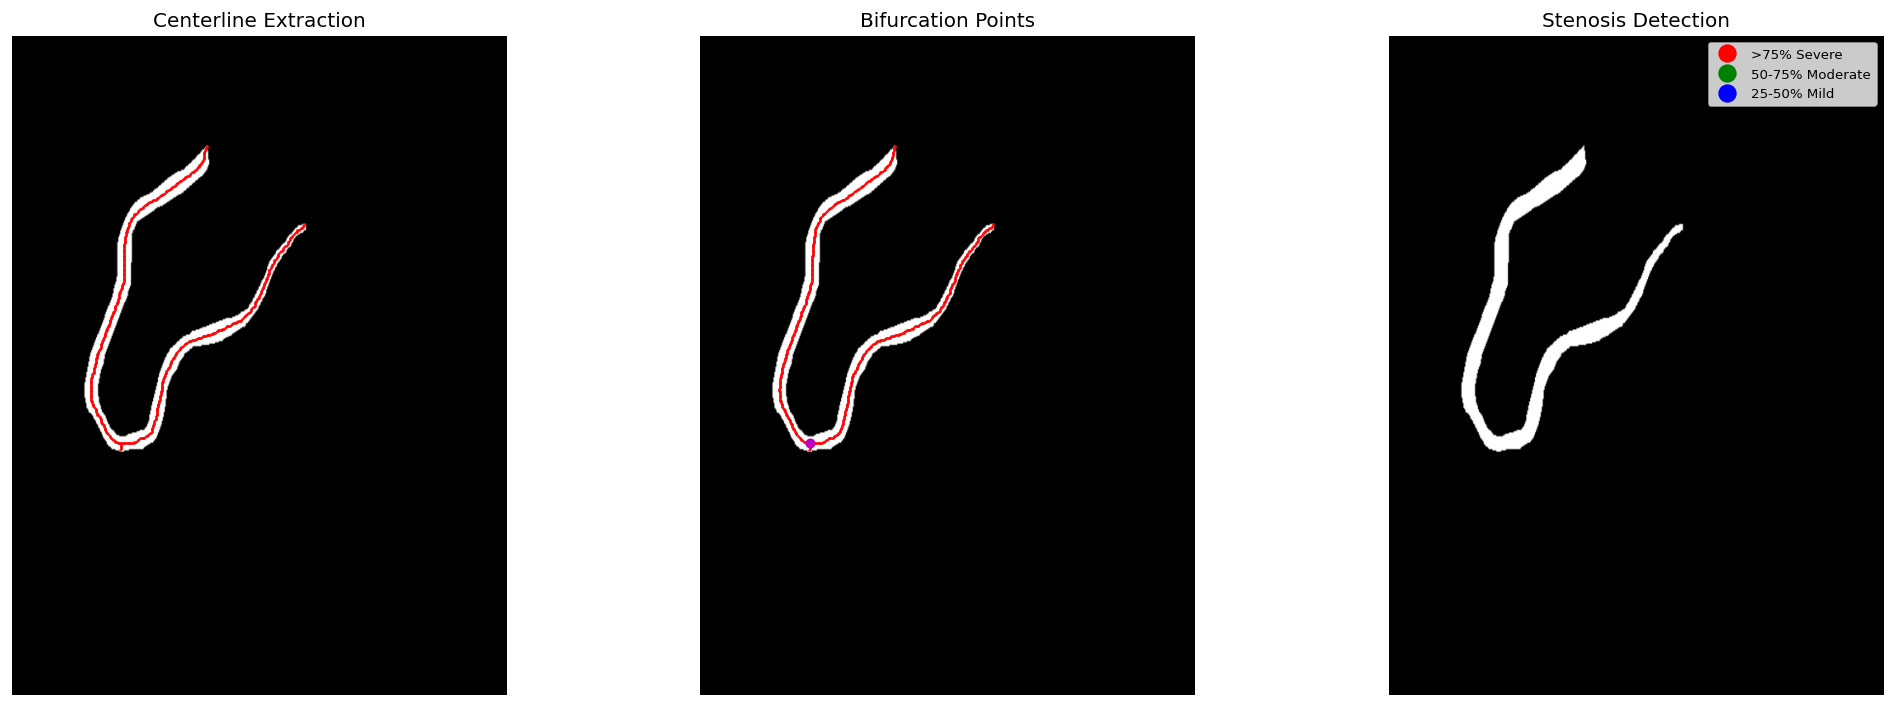

  Processing 102.png...
  Skeleton points: 2198


In [ ]:
# Batch mode: process all 300 test images
IMAGE_DIR = str(DATA_ROOT / 'images')
MASK_DIR  = str(DATA_ROOT / 'masks')
OUTPUT_DIR = str(PROJECT_ROOT / 'stenosis_results')

os.makedirs(OUTPUT_DIR, exist_ok=True)

images = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(('.png','.jpg','.bmp'))])
print(f'Found {len(images)} images')

for img_name in images:
    img_path = os.path.join(IMAGE_DIR, img_name)
    mask_path = os.path.join(MASK_DIR, img_name)
    if not os.path.exists(mask_path):
        print(f'  Skip {img_name} (no mask)')
        continue
    print(f'  Processing {img_name}...')
    try:
        r = run_stenosis_detection(img_path, mask_path)
        plot_results(r, save_path=os.path.join(OUTPUT_DIR, f'result_{img_name}'))
        plt.close('all')
    except Exception as e:
        print(f'    ERROR: {e}')
print('Batch complete!')